In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import re
import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms
from random import randrange
import inspect
import PIL
from PIL import Image
from typing import Tuple
import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
import tqdm
from tqdm import tqdm_notebook
import time
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
train_on_gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
train_dir = Path('/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/')
test_dir = Path('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset/')

In [3]:
class SimpsonTrainValPath():

  def __init__(self, train_dir, test_dir):
    
    self.train_dir = train_dir
    self.test_dir = test_dir
    self.train_val_files_path = sorted(list(self.train_dir.rglob('*.jpg')))
    self.train_val_files_path = [path for path in self.train_val_files_path]
    self.test_path = sorted(list(self.test_dir.rglob('*.jpg')))
    self.test_path = [path for path in self.test_path]
    self.train_val_labels = [path.parent.name for path in self.train_val_files_path]

  def get_path(self):
      
    train_files_path, val_files_path = train_test_split(self.train_val_files_path, test_size = 0.3, \
                                          stratify=self.train_val_labels)
    
    files_path = {'train': train_files_path, 'val': val_files_path}
    
    return files_path, self.test_path
  
  def get_n_classes(self):
    return len(np.unique(self.train_val_labels))

In [4]:
SimpsonTrainValPath = SimpsonTrainValPath(train_dir, test_dir)
train_path, test_path = SimpsonTrainValPath.get_path()

In [5]:
class SimpsonsDataset(Dataset):

    def __init__(self, files_path, data_transforms):
      self.files_path = files_path
      self.transform = data_transforms
      
      if 'test' not in str(self.files_path[0]):
        self.labels = [path.parent.name for path in self.files_path]
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        
        with open('label_encoder.pkl', 'wb') as le_dump_file:
            pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):

      img_path = str(self.files_path[idx]) 
      image = Image.open(img_path)
      image = self.transform(image)
      
      if 'test' in str(self.files_path[0]):
        return image
      else: 
        label_str = str(self.files_path[idx].parent.name)
        label = self.label_encoder.transform([label_str]).item()
        
        return image, label

In [6]:
input_size = 224
batch_size = 32
train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
valid_transform = train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [7]:
train_dataset = SimpsonsDataset(train_path['train'], data_transforms=train_transform)
val_dataset = SimpsonsDataset(train_path['val'], data_transforms=valid_transform)
test_dataset = SimpsonsDataset(test_path, data_transforms=valid_transform)

In [8]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
valid_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
dataloaders_dict = {'train': train_dataloader, 'val': valid_dataloader}
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=2)

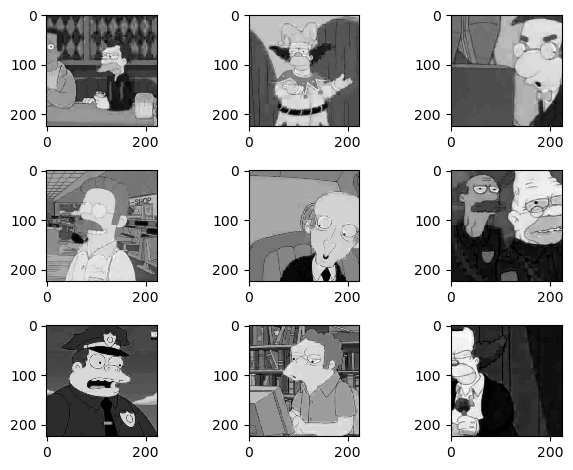

In [9]:
batch, _ = next(iter(train_dataloader))
figure = plt.figure()

for index in range(9):
    plt.subplot(3, 3, index + 1)
    plt.tight_layout()
    plt.imshow(batch[index][0], cmap='gray', interpolation='none')

In [10]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

In [11]:
feature_extract = False

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 8, 5, padding='same')
        self.conv2 = nn.Conv2d(8, 16, 3, padding='same')
        self.conv3 = nn.Conv2d(16, 24, 3, padding='same')
        self.conv4 = nn.Conv2d(24, 32, 3, padding='same')
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(32 * 56 * 56, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 42)

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = F.relu(x)
        
        drop = nn.Dropout(p=0.5)
        
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)

        drop = nn.Dropout(p=0.5)
        
        x = F.relu(self.fc1(x))
        
        x = drop(x)
        
        x = F.relu(self.fc2(x))
        
        x = drop(x)
        
        x = self.fc3(x)
        
        return x

In [13]:
num_classes = 42
model = ConvNet()
set_parameter_requires_grad(model, feature_extract)
[(name, parameter.shape) for name, parameter in model.named_parameters()]

[('conv1.weight', torch.Size([8, 3, 5, 5])),
 ('conv1.bias', torch.Size([8])),
 ('conv2.weight', torch.Size([16, 8, 3, 3])),
 ('conv2.bias', torch.Size([16])),
 ('conv3.weight', torch.Size([24, 16, 3, 3])),
 ('conv3.bias', torch.Size([24])),
 ('conv4.weight', torch.Size([32, 24, 3, 3])),
 ('conv4.bias', torch.Size([32])),
 ('fc1.weight', torch.Size([4096, 100352])),
 ('fc1.bias', torch.Size([4096])),
 ('fc2.weight', torch.Size([1024, 4096])),
 ('fc2.bias', torch.Size([1024])),
 ('fc3.weight', torch.Size([42, 1024])),
 ('fc3.bias', torch.Size([42]))]

In [14]:
# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(params_to_update, lr=5e-4, weight_decay=1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Params to learn:
	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 conv3.weight
	 conv3.bias
	 conv4.weight
	 conv4.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias
	 fc3.weight
	 fc3.bias


In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, is_inception=False):
    since = time.time()
    train_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_acc_history

In [16]:
criterion = nn.CrossEntropyLoss()
num_epochs = 15
model, train_loss_history, val_acc_history = train_model(model, dataloaders_dict, criterion,
                                        optimizer, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 2.1321 Acc: 0.4189
val Loss: 1.4035 Acc: 0.6221

Epoch 1/14
----------
train Loss: 0.8736 Acc: 0.7691
val Loss: 0.7178 Acc: 0.8061

Epoch 2/14
----------
train Loss: 0.2737 Acc: 0.9253
val Loss: 0.5995 Acc: 0.8578

Epoch 3/14
----------
train Loss: 0.1314 Acc: 0.9622
val Loss: 0.6151 Acc: 0.8663

Epoch 4/14
----------
train Loss: 0.0996 Acc: 0.9712
val Loss: 0.5516 Acc: 0.8863

Epoch 5/14
----------
train Loss: 0.0854 Acc: 0.9762
val Loss: 0.5826 Acc: 0.8873

Epoch 6/14
----------
train Loss: 0.0806 Acc: 0.9781
val Loss: 0.6065 Acc: 0.8820

Epoch 7/14
----------
train Loss: 0.0725 Acc: 0.9812
val Loss: 0.5874 Acc: 0.8895

Epoch 8/14
----------
train Loss: 0.0593 Acc: 0.9832
val Loss: 0.6420 Acc: 0.8889

Epoch 9/14
----------
train Loss: 0.0589 Acc: 0.9842
val Loss: 0.6093 Acc: 0.8852

Epoch 10/14
----------
train Loss: 0.0580 Acc: 0.9839
val Loss: 0.6496 Acc: 0.8945

Epoch 11/14
----------
train Loss: 0.0532 Acc: 0.9867
val Loss: 0.6429 Acc: 0.8920

Ep

Text(0, 0.5, 'Loss')

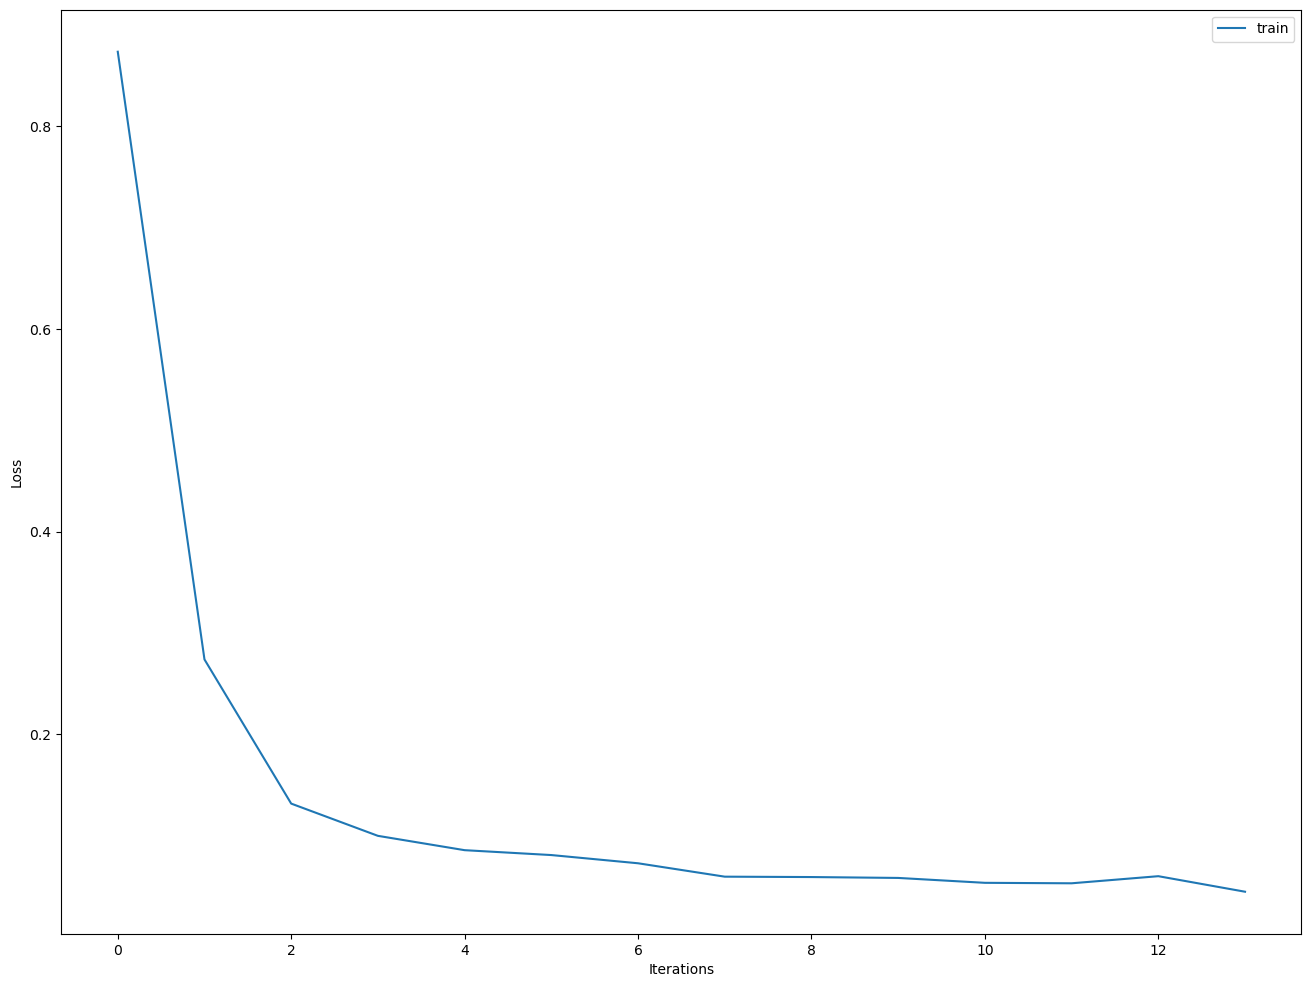

In [73]:
fig = plt.figure(figsize=(16, 12))

plt.plot(train_loss_history[1:], label='train')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

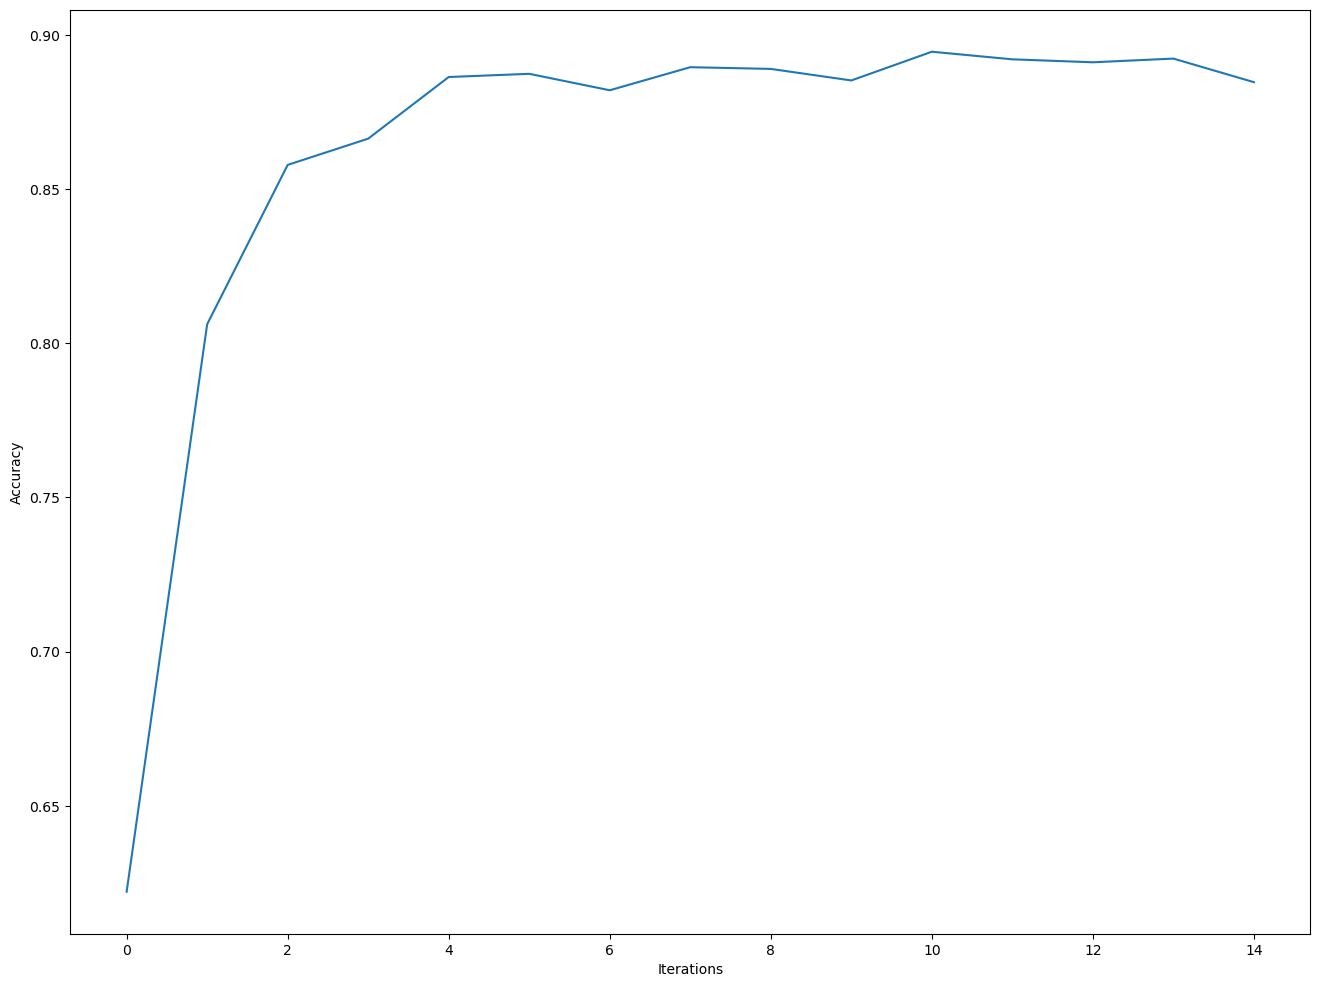

In [74]:
fig = plt.figure(figsize=(16, 12))
accs = [acc.cpu() for acc in val_acc_history]
plt.plot(accs)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')


In [75]:

def predict_one_sample(model, img_tensor, device=device):
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        model.eval()
        y_hat = model(img_tensor).cpu()
        y_pred = torch.nn.functional.softmax(y_hat, dim=1).numpy()
    return y_pred



In [76]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


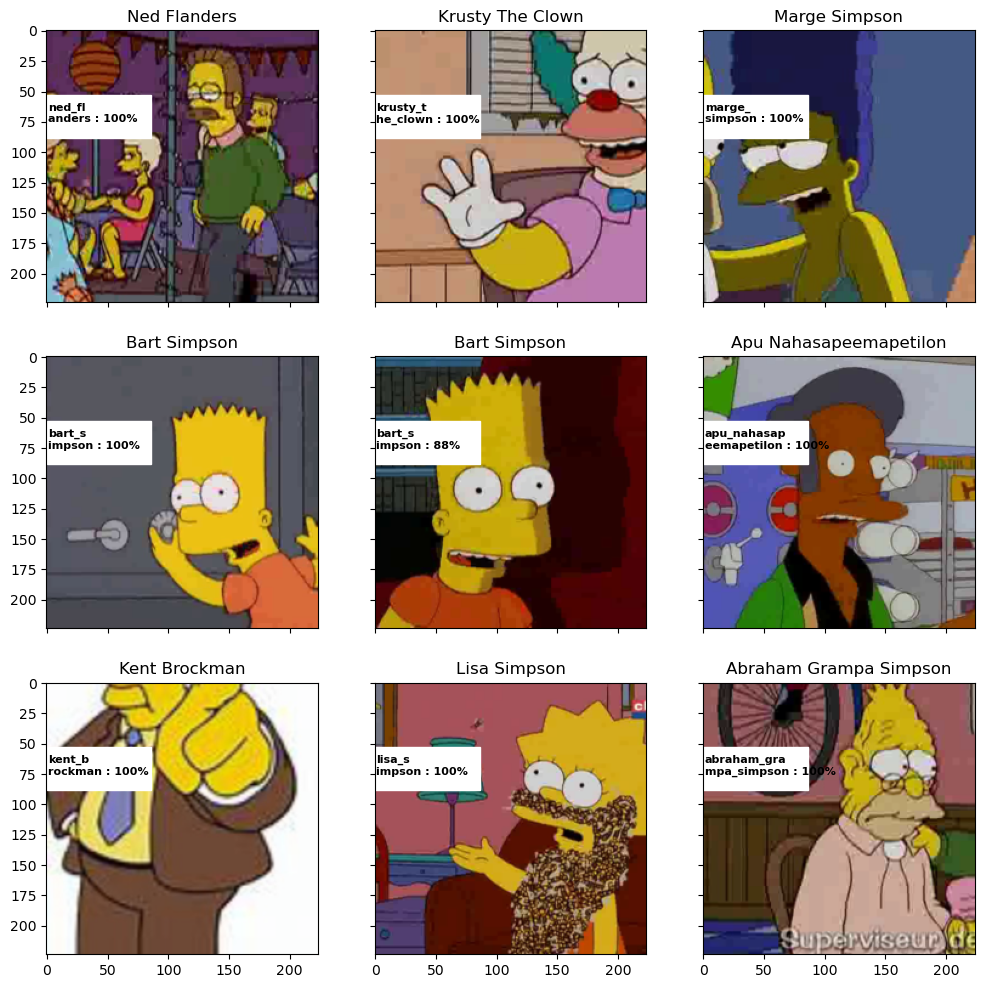

In [77]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), \
                        sharey=True, sharex=True)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    # inverse_transform это метод LabelEncoder(), мы закодировали цифрами классы, с помощью inverse_transform из чисел вернём название класса
    # получаем имя персонажа с заглавных букв
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)

    # добавим область на которой будем выводить вероятность        
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    # получаем вероятность
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [78]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=1).numpy()
    return probs


In [79]:
probs = predict(model, test_dataloader)

In [80]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis = 1 ))
test_filenames = [path.name for path in test_dataset.files_path]

In [81]:
results = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
results.head()

,Id,Expected
0,abraham_grampa_simpson_0.jpg,abraham_grampa_simpson
1,abraham_grampa_simpson_1.jpg,abraham_grampa_simpson
2,abraham_grampa_simpson_10.jpg,abraham_grampa_simpson
3,abraham_grampa_simpson_11.jpg,abraham_grampa_simpson
4,abraham_grampa_simpson_12.jpg,abraham_grampa_simpson


In [82]:
# тут я выделяю только имя персонажа, без _{номер}.jpg и сравниваю с предсказанным именем персонажа
accurate_predictions = results[results['Id'].str.extract(r'(\w+(_\w+)?)_\d')[0] == results['Expected']] 
accurate_predictions.head()

,Id,Expected
0,abraham_grampa_simpson_0.jpg,abraham_grampa_simpson
1,abraham_grampa_simpson_1.jpg,abraham_grampa_simpson
2,abraham_grampa_simpson_10.jpg,abraham_grampa_simpson
3,abraham_grampa_simpson_11.jpg,abraham_grampa_simpson
4,abraham_grampa_simpson_12.jpg,abraham_grampa_simpson


In [83]:
accuracy = accurate_predictions.shape[0] / results.shape[0]
print('Точность на тестовом датасете: {:0.4f}'.format(accuracy))

Точность на тестовом датасете: 0.9636
